In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#List table columns
print(f"Measurement table columns: {[column.key for column in Measurement.__table__.columns]}")
print(f"Station table columns: {[column.key for column in Station.__table__.columns]}")

Measurement table columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station table columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# from sqlalchemy import desc

# Exploratory Climate Analysis

In [ ]:






# Use Pandas Plotting with Matplotlib to plot the data


In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find date of lastest measurement in Measurement table and covert to date object
last_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = datetime.strptime(last_date_result[0], '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
from dateutil.relativedelta import relativedelta

first_date = last_date.replace(year=last_date.year - 1)
first_date = last_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
qry = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date.between(first_date, last_date)).\
        order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(qry)
df_precip.set_index("date", inplace = True) 

# Sort the dataframe by date
df_precip.sort_values("date", ascending=True, inplace=True)

df_precip.head()

,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


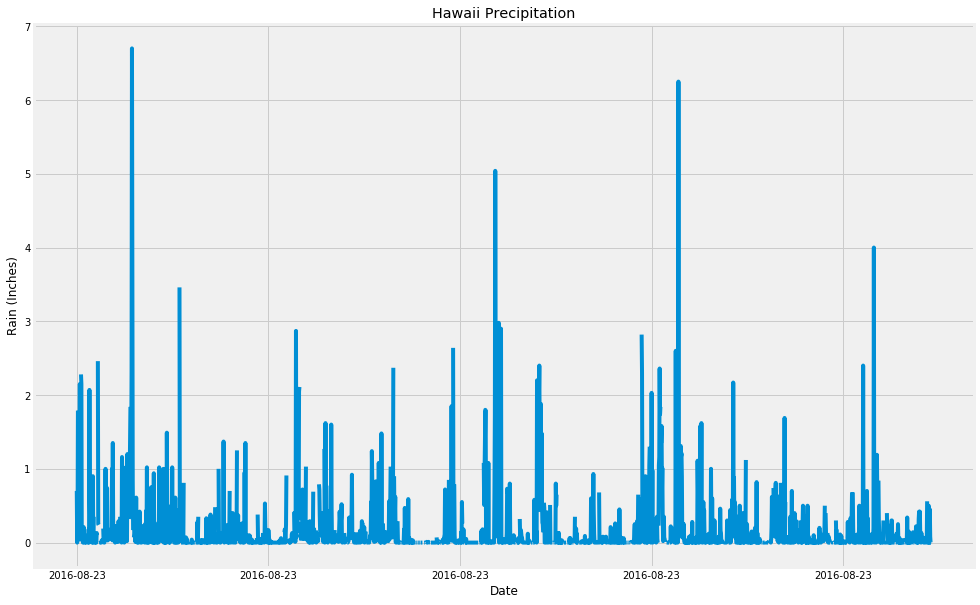

In [72]:
#  ax = df_precip.plot(kind='bar', figsize=(15, 10), title ="Hawaii Precipitation",legend=False)
ax = df_precip.plot( figsize=(15, 10), legend=False, title ="Hawaii Precipitation")

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rain (Inches)", fontsize = 12)



###########################################
####COME BACK TO
# ax.set_xlim([first_date, last_date])
# ax.set_xticklabels(df_precip.index)
# ax.set_xticklabels(df_precip['date'])
#ax.xaxis.set_ticks(df_precip.index)



plt.show()

In [ ]:


end_date = [row.date for row in session.query(Measurement.date).order_by(desc(Measurement.date)).limit(1)][0]
# print(max_date)

# type(session.query(Measurement.date).filter((Measurement.id ==1)).limit(1))

# type(dt.datetime(end_date))
print(end_date)
print(date.month)

first_row = session.query(Measurement.date, func.max(Measurement.date))



[column.key for column in Measurement.__table__.columns]

first_entry = session.query(Measurement)  #.get(1)

# for entry in first_entry:
#     print(type(entry))


    
# print(first_entry.__str__)
# type(first_entry)
# for i in first_entry:
#     print(i.id)

first_entry.column_descriptions